# Vibration modes of membranes with convex polygonal shape

Nicolás Guarín Zapata

## Description

The idea is to find the modes of vibration for membranes with (convex) polygonal shape. These are found as eigenvalues for the [Helmholtz equation](http://en.wikipedia.org/wiki/Helmholtz_equation)
$$\left(\nabla^2 + \frac{\omega^2}{c^2}\right) u(x,y) \equiv \left(\nabla^2 + k^2\right) u(x,y) = 0\ \forall\ (x,y)\in\Omega\enspace ,$$
with boundaries fixed, i.e.
$$u(x,y)=0\ \forall\ (x,y) \in \partial\Omega \enspace .$$

This quation is common in Mathematical Physics, e.g., in the solution of Acoustics, Quantum Mechanics and Electromagnetism problems [[1]](#References).

We have an equivalent formulation for this problem, i.e., a [variational](http://en.wikipedia.org/wiki/Calculus_of_variations) (energy) formulation. Starting from the energy (functional) $E$,
$$ E = U + k^2T \equiv \underbrace{\int\limits_\Omega \nabla u \cdot \nabla u\ dx\ dy}_{U} +  k^2\underbrace{\int\limits_\Omega u^2 dx\ dy}_{T} \enspace ,$$
that is equivalent to the original differential equation -under some assumptions [[2]](#References).

This problem has analytical solution for some shapes like rectangles, circles and ellipses. So, here we use an approximate method to find the solutions: the [Ritz method](http://en.wikipedia.org/wiki/Ritz_method). The Ritz method is the very same method used in most of Finite Element Formulations. I will describe the method in here, but it should not be read as a formal one, it is more like a cartoon-ish formulation.

Let's propose a solution of the form
$$\hat{u}(x,y) = \sum_{n=1}^{N} c_{n} f_n(x,y) \enspace ,$$
where $f_n(x,y)$ are known functions, they should be a subset of a complete basis for the space of solutions... but, for this notebook they are just polynomials (due to ease in integrate them). So, what we don't know in this equations are the coefficients. Good thing there is a theorem that says that the solution of the problem is an extremum (minimum in this case) of the functional. In our case, that means solving the system of equations
$$\frac{\partial E}{\partial c_{n}} = 0 \enspace .$$
What lead us to
$$[K]\lbrace\mathbf{c}\rbrace = k^2[M]\lbrace\mathbf{c}\rbrace \enspace ,$$
or
$$\left[\frac{\partial^2 U}{\partial c_i \partial c_j}\right]\lbrace \mathbf{c}\rbrace = k^2 \left[\frac{\partial^2 T}{\partial c_i \partial c_j}\right]\lbrace \mathbf{c}\rbrace \enspace .$$

Hence, we have the formula for computing the components of the (stiffness and mass) matrices and then solve the resulting eigenvalue problem.

## Computing the integrals

The last ingredient missing is the calculation of the integral $U$ and $T$. We want to compute the integral of known functions $f_n(x,y)$; the main problem is the domain (in other words, the limits of the integrals). The following image shows a (convex) heptagon and a subdivision in triangles that use the centroid as one of the vertices. The idea is to subdivide the integral into integrals over the non-overlapping triangles.

<img src="./img/polygon.png" alt="Polygon Image" style="width:300px">


To achieve that (easily) we can transform the domain of integration into a _canonical_ domain, as depicted in the next image.


<center><img src="./img/transformation.png" alt="Transformation Image" style="width:600px"></center>

For this simple case the transformation is given by
$$\begin{pmatrix}x\\ y \end{pmatrix} = \mathbf{T}\begin{pmatrix}r\\ s \end{pmatrix} \equiv [J]\begin{pmatrix}r\\ s \end{pmatrix}  + \begin{pmatrix}x_A\\ y_A \end{pmatrix} \enspace ,$$
with
$$[J] = \begin{bmatrix} x_B - x_A &x_C - x_A\\ y_B - y_A &y_C - y_A \end{bmatrix} \enspace .$$
And the inverse transformation reads
$$\begin{pmatrix}r\\ s \end{pmatrix} = \mathbf{T}^{-1}\begin{pmatrix}x\\ y \end{pmatrix} \equiv [J^{-1}]\begin{pmatrix}x\\ y \end{pmatrix}  + \frac{1}{\det J}\begin{pmatrix}x_A y_C - x_C y_A\\ x_By_A - x_A y_B \end{pmatrix} \enspace ,$$
where
$$[J^{-1}] = \frac{1}{\det J}\begin{bmatrix}  y_C - y_A &x_A - x_C\\ y_A - y_B &x_B - x_A \end{bmatrix} \enspace .$$

Then, to compute the integrals we [tranform the domain and the functions of interest](http://en.wikipedia.org/wiki/Integration_by_substitution), i.e., $u^2(x,y)$ and $\nabla u(x,y) \cdot \nabla u(x,y)$. And the integrals over one of the triangles are expressed as
$$\int\limits_{\Omega_k} u^2(x,y)\ dx\ dy = \int\limits_{0}^{1}\int\limits_{0}^{1-s} u^2(\phi(r,s))\ \det J\ dr\ ds \enspace ,$$
and
$$\int\limits_{\Omega_k} [\nabla u(x,y))]^2\ dx\ dy = \int\limits_{0}^{1}\int\limits_{0}^{1-s} [\nabla u(\phi(r,s))]^2\ \det J\ dr\ ds \enspace ,$$
in this case we are first computing $\nabla u(x,y)$ and later making the change of variable $(x,y) = \phi(r,s)$, it can be done the other way but that implies the use of the [chain rule](http://en.wikipedia.org/wiki/Chain_rule). Thus, we loop over the triangles, compute the Jacobian transform the functions, solve each integral and add it up.

## Algorithm

In [1]:
from __future__ import division
import numpy as np
from scipy.linalg import eigh
from sympy import symbols, lambdify, init_printing, cos, sin,  pi, expand, Matrix, diff, integrate, Poly
from sympy.plotting import plot3d
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [2]:
x, y, r, s= symbols('x y r s')
%matplotlib inline
init_printing()

### Compute the polygon

The polygon is defined as a set of nodes and its conectivity

In [3]:
from time import time
t0 = time()

In [4]:
nsides = 6
poly = [[cos(2*k*pi/nsides), sin(2*k*pi/nsides)] for k in range(0,nsides)]
#poly = [[-1,-1],[1,-1],[1,1],[-1,1]]  # Simplest square
npts = len(poly)
lines = [[k,0] if k==npts-1 else [k,k+1] for k in range(npts)]
centroid = [sum([poly[k][0] for k in range(npts)]), sum([poly[k][1] for k in range(npts)])]

### Polygon plot

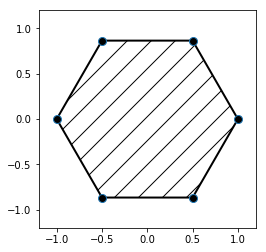

In [5]:
plt.fill(np.array(poly)[:,0], np.array(poly)[:,1], fill=False, ec='k', lw=2, hatch='/')
plt.plot(np.array(poly)[:,0], np.array(poly)[:,1], lw=0, marker='o', ms=8, mfc='k')
plt.axis('image');
plt.xlim(-1.2, 1.2), plt.ylim(-1.2, 1.2);

### Boundary conditions

We need our function to satisfy the boundary conditions, i.e,
$$u(\text{boundary}) = 0 \enspace ,$$
this can be convoluted for a general polygon. The easy way to do it is define a polynomial that is exactly zero when evaluated at the boundary, namely
$$b(x,y) = \prod_{i=1}^{n-1}\left[y - y_i + (x_i - x)\left(\frac{y_i - y_{i+1}}{x_i - x_{i+1}}\right)\right]\left[y- y_n + (x_n - x)\left(\frac{y_n - y_1}{x_n - x_1}\right)\right] \enspace ,$$
being $(x_i,y_i)$ the coordinates of each vertex.

In [6]:
# Polynomial defining the boundaries
def b(x,y,n):
    prod = 1
    for k in range(0, n):
        prod = prod * ((y - poly[lines[k][0]][1])*(poly[lines[k][0]][0] - poly[lines[k][1]][0]) - 
            (x - poly[lines[k][0]][0])*(poly[lines[k][0]][1] - poly[lines[k][1]][1]))
    return prod.expand()

bound = b(x, y, npts)

And the boundary function looks like...

In [7]:
b_num = lambdify((x,y), bound, "numpy")
X,Y = np.mgrid[-1:1:50j, -1:1:50j]
Z = b_num(X,Y)

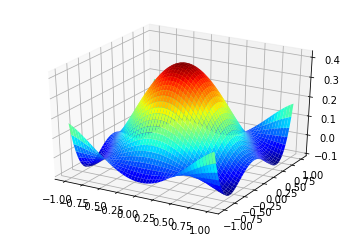

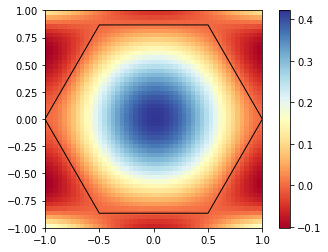

In [8]:
plot3d(bound,(x,-1,1), (y, -1,1), colormap="RdYlBu");
plt.pcolor(X, Y, Z, cmap="RdYlBu")
plt.fill(np.array(poly)[:,0], np.array(poly)[:,1], fill=False, ec='k', lw=1)
plt.axis("image")
plt.colorbar();

### The function

The function is then given by the product of a boundary function and the linear combinations of (nonredundant) functions over the domain
$$\hat{u}(x,y) = b(x,y)\sum\limits_{n=0}^{N-1} c_{n} W_{n}(x,y) \enspace .$$

The terms $W_{n}(x,y)$ are functions that should be linear independent, preferably a complete basis on the space solution. In our case we choose polynomials since we want them to be easilly integrable.

In [9]:
def w_fun(x, y, m, n):
    """ Trial function. """
    c = symbols('c:%d' % (m*n)) # This is the way of define the coefficients c_i
    w = 0
    for i in range(0, m):
        for j in range(0, n):
            w += c[m*j + i] * x**i * y**j
    
    return w, c

def u_fun(x, y, m, n):
    """ Complete function. Contains the boundary and trial functions. """
    w, c =w_fun(x, y, m, n)
    return b(x, y, npts) * w, c

m = 2
n = 2
u, c = u_fun(x, y, m, n)

### Matrices computation

As expressed above the matrices are computed as
$$[K_{ij}] = \left[\frac{\partial^2 U}{\partial c_i \partial c_j}\right]\enspace ,$$
$$[M_{ij}] = \left[\frac{\partial^2 T}{\partial c_i \partial c_j}\right]\ \enspace .$$

In [10]:
u_c = Poly(u, c).coeffs()
dx_c = Poly(u.diff(x), c).coeffs()
dy_c = Poly(u.diff(y), c).coeffs()

In [11]:
Kaux = Matrix(m*n, m*n, lambda ii, jj: dx_c[ii]*dx_c[jj] + dy_c[ii]*dy_c[jj])
Maux = Matrix(m*n, m*n, lambda ii, jj: u_c[ii]*u_c[jj])
K = Matrix(m*n, m*n, lambda i,j: 0)
M = Matrix(m*n, m*n, lambda i,j: 0)

In [12]:
for j in range(len(lines)):
    A = [poly[lines[j][0]][0], poly[lines[j][0]][1]]
    B = [poly[lines[j][1]][0], poly[lines[j][1]][1]]
    C = [centroid[0], centroid[1]]
    J = Matrix([[B[0] - A[0], C[0] - A[0]],
                [B[1] - A[1], C[1] - A[1]]])
    detJ = J.det()
    trans = J * Matrix([[r],[s]]) + Matrix(A)
    for row in range(m*n):
        for col in range(row, m*n):
            K_inte = Kaux[row, col].subs({x:trans[0], y:trans[1]})
            M_inte = Maux[row, col].subs({x:trans[0], y:trans[1]})
            K_inte = integrate(K_inte*detJ, (r, 0, 1-s), (s, 0, 1))
            M_inte = integrate(M_inte*detJ, (r, 0, 1-s), (s, 0, 1))
            K[row, col] += K_inte
            M[row, col] += M_inte
            if row != col:
                K[col, row] += K_inte
                M[col, row] += M_inte

The _face_ of the matrices looks like

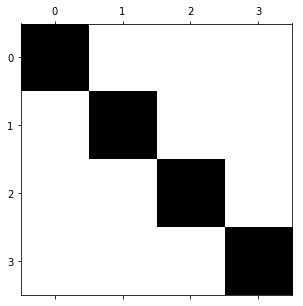

In [13]:
plt.figure(figsize=(5,5))
plt.spy(K.evalf());

So far, everything was done in an analytical fashion. This cannot be the case for the solution of eigenvalue problems, since they [need to](http://en.wikipedia.org/wiki/Abel%E2%80%93Ruffini_theorem) be solved in an iterative way. Thus, we convert our analytical matrices to numpy arrays and proceed

In [14]:
Kn = np.array(K).astype(np.float64)
Mn = np.array(M).astype(np.float64)

In [15]:
vals, vecs = eigh(Kn, Mn, eigvals=(0,3))
vals

array([  7.26184612,  18.19131025,  18.19131025,  33.03588824])

### Plot of the modes

They are note pretty neat since they are plotting the polynomials outside their region...

In [16]:
X,Y = np.mgrid[-1:1:200j, -1:1:200j]
verts = np.array(poly, float)

In [17]:
path = Path(verts)
mask = 0*X;
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        mask[i,j] = path.contains_point((X[i,j],Y[i,j]))

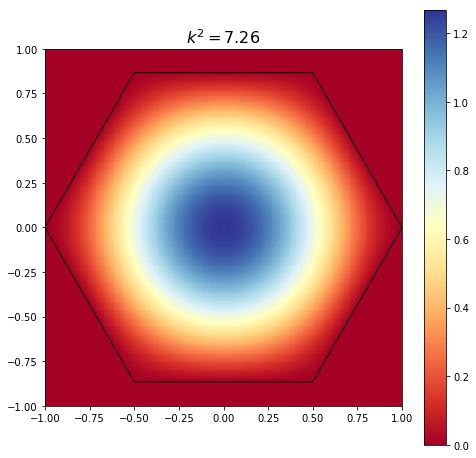

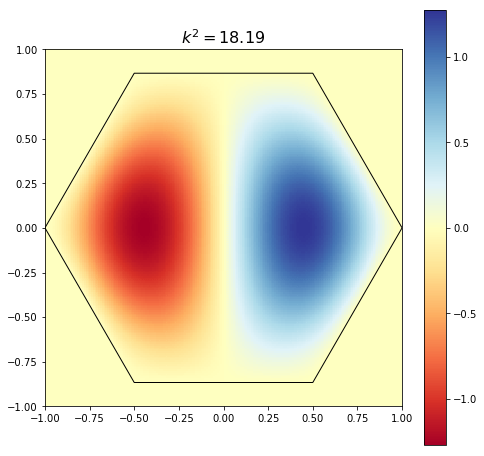

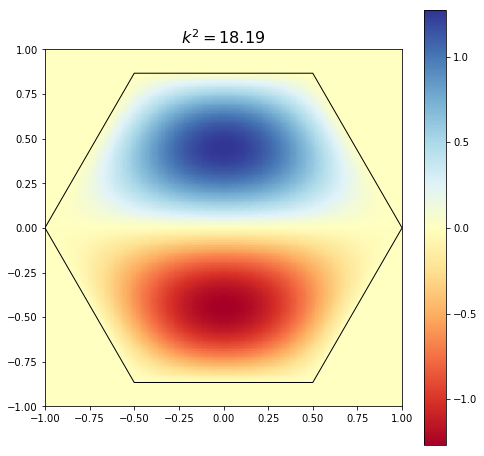

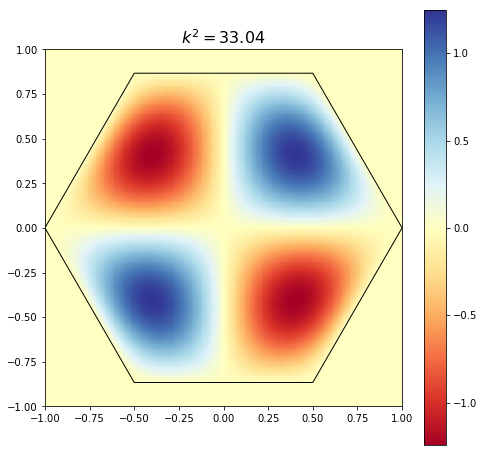

In [18]:
for i in range(len(vals)):
    U =  u.subs(dict({c[j]: vecs[j,i] for j in range(m*n)}))
    vecU = lambdify((x,y), U, "numpy")
    Z = vecU(X,Y)*mask
    plt.figure(figsize=(8,8))
    plt.title(r"$k^2=%.2f$" % vals[i], size=16);
    plt.fill(np.array(poly)[:,0], np.array(poly)[:,1], fill=False, ec='k', lw=1)
    plt.pcolor(X, Y, Z, cmap="RdYlBu")
    plt.axis("image")
    plt.colorbar();    

## References

1. Arfken, George B., and Hans J. Weber. Mathematical Methods For Physicists International Student Edition. Academic press, 2005.
2. Reddy, J. N. "Applied Functional Analysis And Variational Methods In Engineering,  Mcgraw-Hill College Pa." (1986): 546.

In [19]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()

In [20]:
print "Elapsed time: ", time() - t0

SyntaxError: invalid syntax (<ipython-input-20-4ef012a9ef51>, line 1)